# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# magic word for producing visualizations in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

This section will be similar to the corresponding project in Term 1 of the program, but the datasets now include more features that you can potentially use. You'll begin the project by using unsupervised learning methods to analyze attributes of established customers and the general population in order to create customer segments.

In [2]:
# load in the data
azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/anaconda3/envs/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Exploration

In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


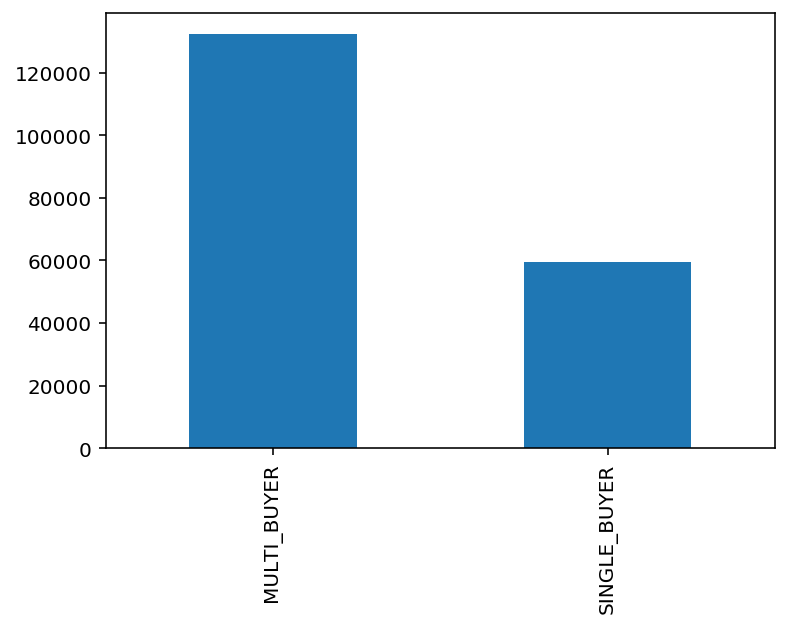

In [5]:
customers['CUSTOMER_GROUP'].value_counts().plot(kind='bar')

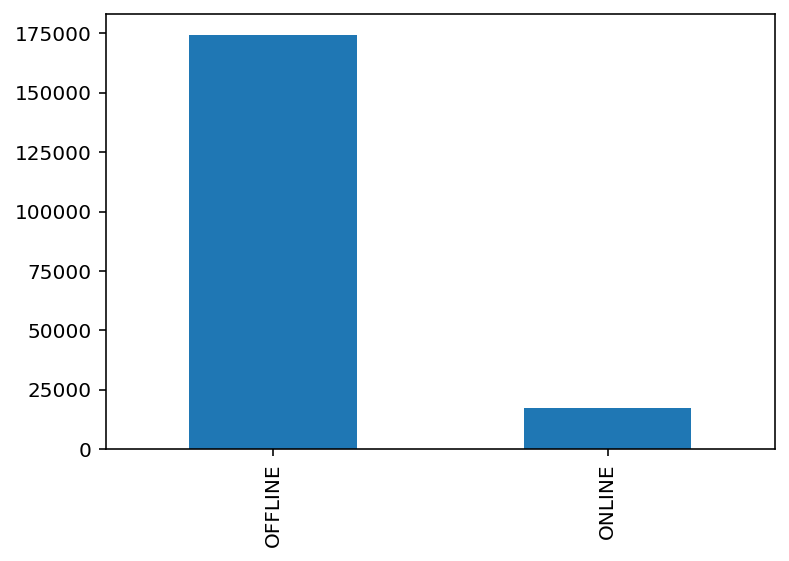

In [6]:
customers['ONLINE_PURCHASE'].replace({0: "OFFLINE", 1: "ONLINE"}).value_counts().plot(kind='bar')

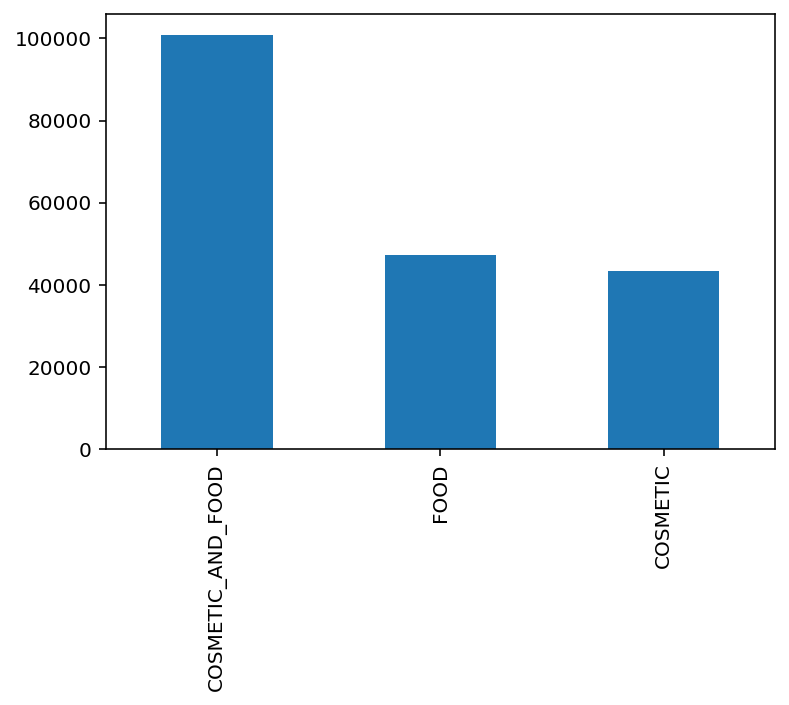

In [7]:
customers['PRODUCT_GROUP'].value_counts().plot(kind='bar')

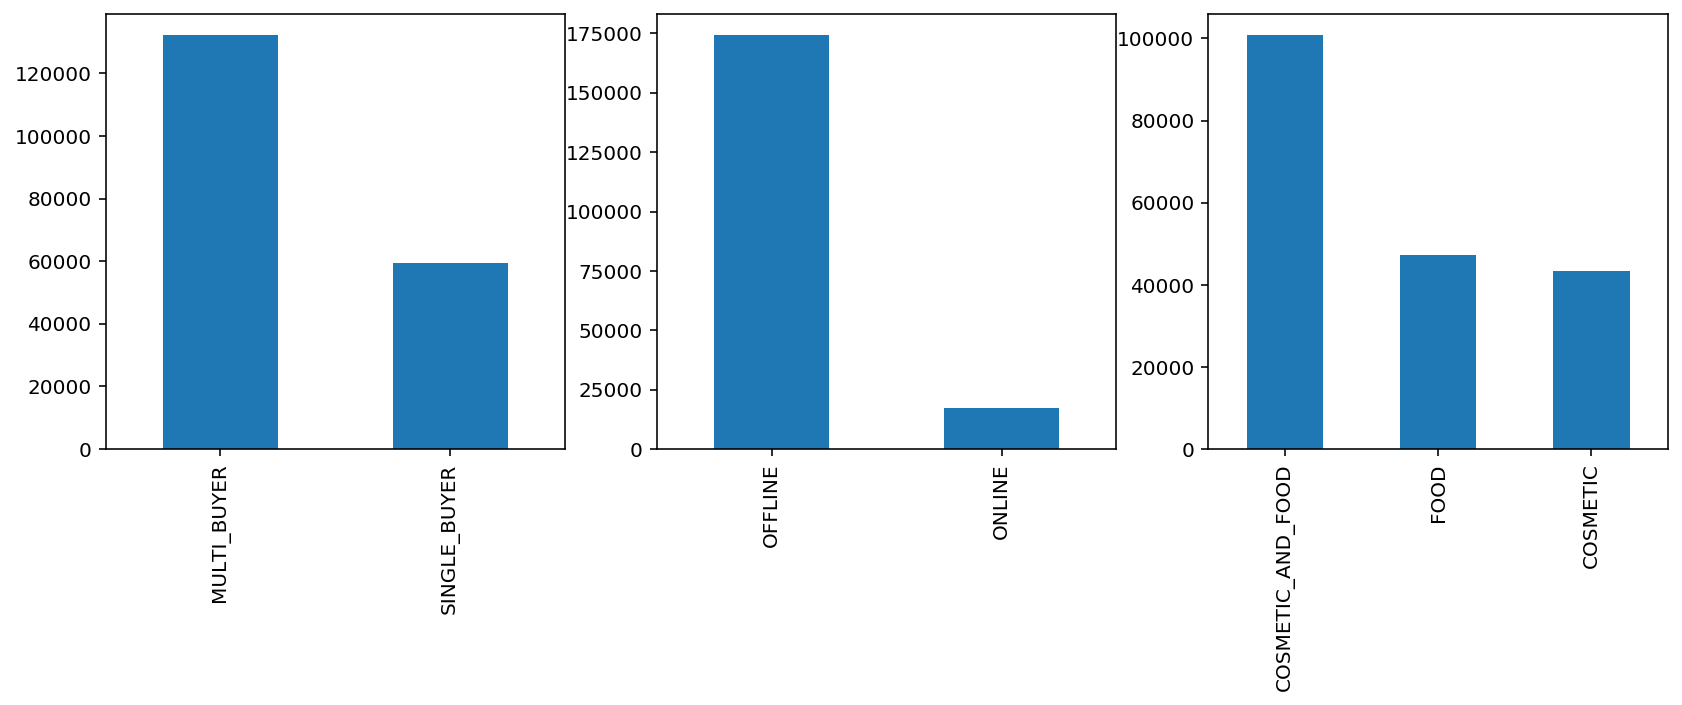

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))

customers['CUSTOMER_GROUP'].value_counts().plot(kind='bar', ax=ax[0])
customers['ONLINE_PURCHASE'].replace({0: "OFFLINE", 1: "ONLINE"}).value_counts().plot(kind='bar', ax=ax[1])
customers['PRODUCT_GROUP'].value_counts().plot(kind='bar',ax=ax[2])

fig.savefig('customer_types.png', dpi=500, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

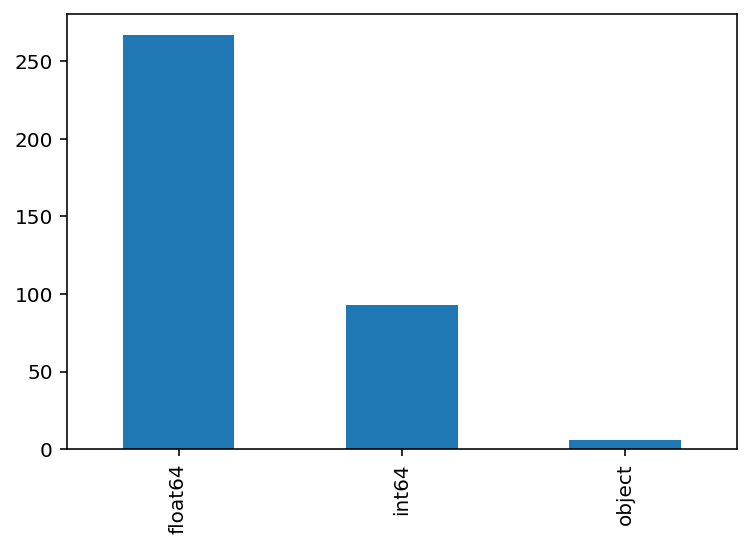

In [9]:
azdias.dtypes.value_counts().plot(kind='bar')

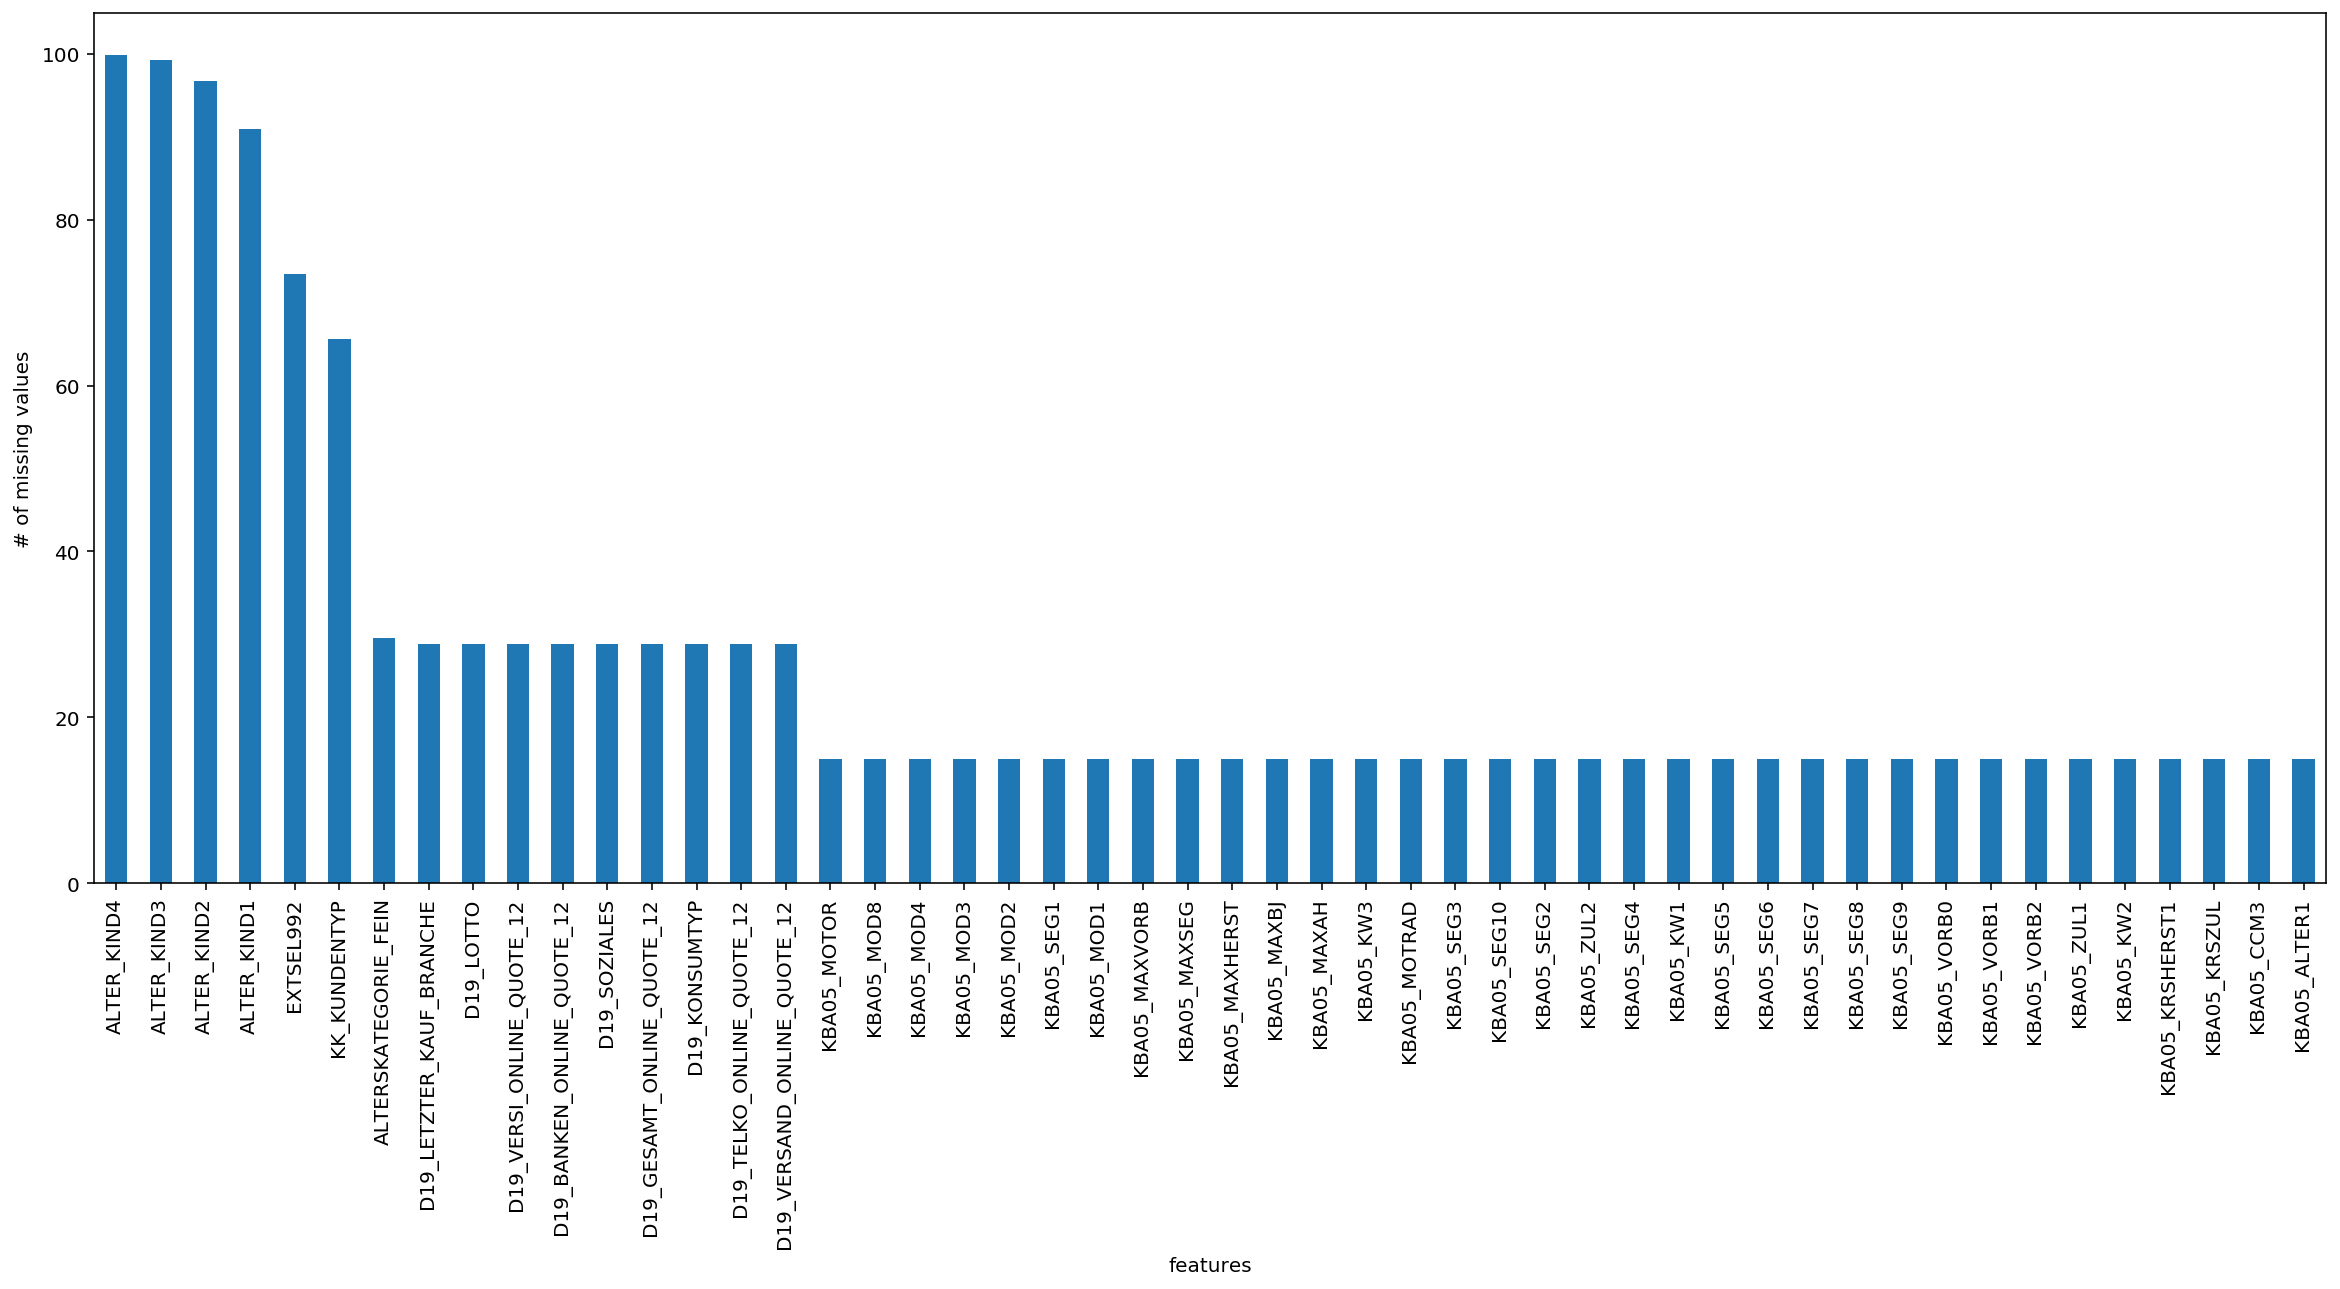

In [10]:
azdias_na = azdias.isnull().sum() / len(azdias) * 100

# visualise natually missing data
(azdias_na.sort_values(ascending=False)[:50].plot(kind='bar', figsize=(20,8)))
plt.ylabel('# of missing values', size=10)
plt.xlabel('features', size=10)
plt.savefig('feature_missing_values.png', dpi=500, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

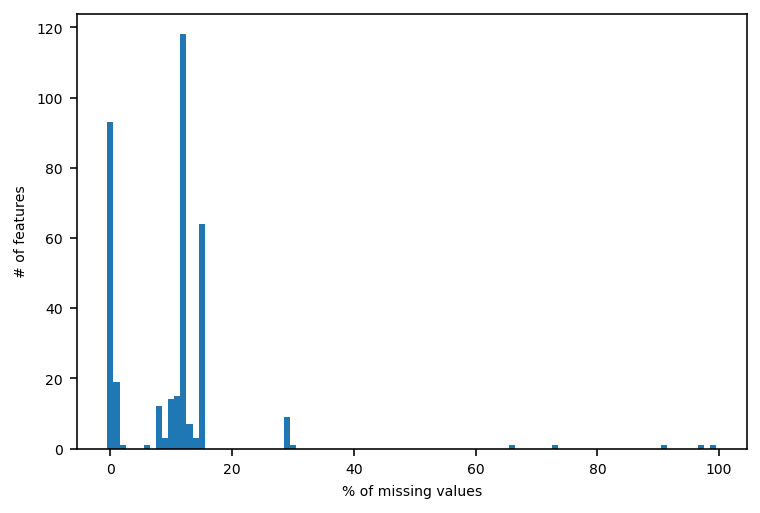

In [11]:
plt.hist(azdias_na, np.arange(min(azdias_na)-0.5, max(azdias_na)+0.5))
plt.xlabel('% of missing values', size=7)
plt.ylabel('# of features', size=7)
plt.tick_params(axis='both', which='major', labelsize=7)
plt.tick_params(axis='both', which='minor', labelsize=7)
plt.savefig('missing_values.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

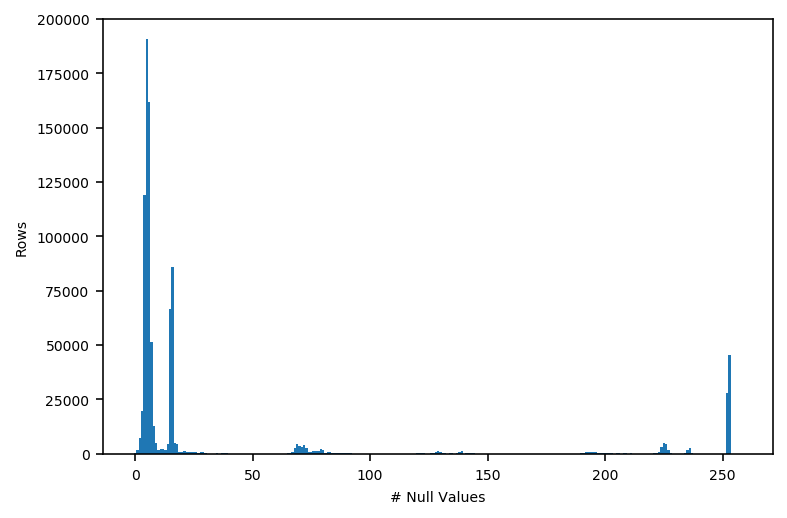

In [12]:
# How much data is missing in each row of the dataset?
azdias_na_row = azdias.isnull().sum(axis=1)
plt.hist(azdias_na_row, np.arange(min(azdias_na_row)-0.5, max(azdias_na_row)+0.5))
plt.xlabel('# Null Values', size=7)
plt.ylabel('Rows', size=7)
plt.tick_params(axis='both', which='major', labelsize=7)
plt.tick_params(axis='both', which='minor', labelsize=7)
plt.savefig('missing_row_values.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

## Handling the Missing Data

### Replace unknown values with NaN

In [13]:
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1, sheet_name='Tabelle1', index_col=[0, 1, 2]).reset_index()
feat_info.drop('level_0', axis=1, inplace=True)
feat_info_levels = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1, index_col=[0, 1]).reset_index()
feat_info_levels.drop('level_0', axis=1, inplace=True) 

feat_info_levels.head()
feat_info[feat_info.Attribute=='CAMEO_DEUG_2015']

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,1,upper class
53,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,2,upper middleclass
54,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,3,established middleclasse
55,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,5,active middleclass
57,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,6,low-consumption middleclass
58,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,7,lower middleclass
59,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,8,working class
60,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,9,urban working class


In [14]:
attributes_we_have_info_about = np.intersect1d(feat_info.Attribute.unique(), np.array(azdias.columns))
attributes_we_dont_have_info = np.setdiff1d(np.array(azdias.columns), feat_info.Attribute.unique())

In [15]:
unknown_values = ['unknown', 'unknown / no main age detectable', 'no transactions known', 'numeric value (typically coded from 1-10)',
                 'numeric value (typically coded from 1-3)', 'no transaction known']
azdias_info = feat_info[(feat_info.Attribute.isin(attributes_we_have_info_about)) & (feat_info.Meaning.isin(unknown_values))]

In [16]:
#Load revised feature info
feat_info = pd.read_csv('arvato_data/feature_info.csv')

In [17]:
feat_info.head()

,Attribute,Description,Meaning,missing_or_unknown,Type
0,AGER_TYP,best-ager typology,unknown,-1,Ordinal
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,unknown,"-1, 0",Ordinal
2,ALTER_HH,main age within the household,unknown / no main age detectable,0,Ordinal
3,ANREDE_KZ,gender,unknown,"-1, 0",Binary
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,numeric value (typically coded from 1-10),0,Numeric


In [18]:
feat_info.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 5 columns):
Attribute             366 non-null object
Description           270 non-null object
Meaning               251 non-null object
missing_or_unknown    239 non-null object
Type                  366 non-null object
dtypes: object(5)
memory usage: 14.4+ KB


In [19]:
# Set attribute as index for `feat_info` dataframe
feat_info.set_index('Attribute', inplace=True)

In [20]:
# Delete columns found in the features not found in the general population dataframe
feat_extra = np.setdiff1d(feat_info.index, azdias.columns, assume_unique=True)
feat_info.drop(feat_extra, inplace=True)
feat_info.shape

(366, 4)

In [21]:
feat_info = feat_info[~feat_info['missing_or_unknown'].isna()]
feat_info.head()

,Description,Meaning,missing_or_unknown,Type
Attribute,,,,
AGER_TYP,best-ager typology,unknown,-1,Ordinal
ALTERSKATEGORIE_GROB,age classification through prename analysis,unknown,"-1, 0",Ordinal
ALTER_HH,main age within the household,unknown / no main age detectable,0,Ordinal
ANREDE_KZ,gender,unknown,"-1, 0",Binary
ANZ_HAUSHALTE_AKTIV,number of households in the building,numeric value (typically coded from 1-10),0,Numeric


In [22]:
feat_info.missing_or_unknown = [list(map(int, i.split(','))) for i in feat_info.missing_or_unknown]

In [23]:
# Convert missing or unknown values to NaNs
for col in azdias:
    if col in feat_info.index.tolist():
        mask = azdias[col].isin(feat_info.at[col, 'missing_or_unknown'])
        azdias.at[mask, col] = np.NaN

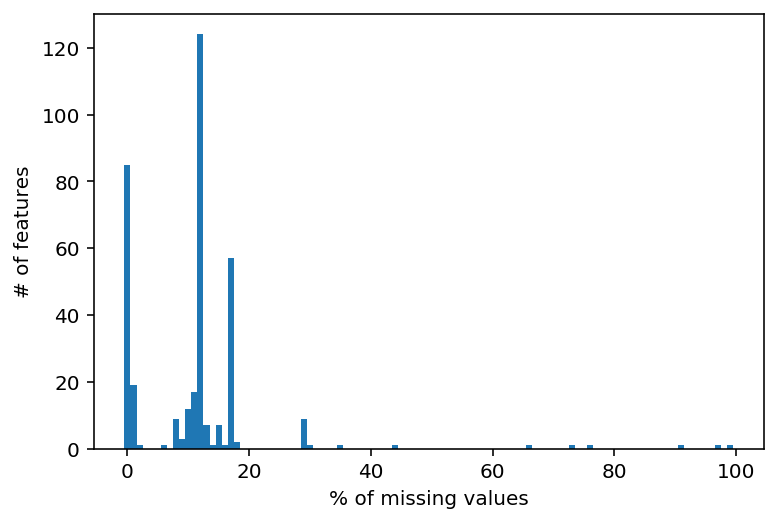

In [24]:
azdias_na = azdias.isnull().sum() / len(azdias) * 100
plt.hist(azdias_na, np.arange(min(azdias_na)-0.5, max(azdias_na)+0.5))
plt.xlabel('% of missing values')
plt.ylabel('# of features')
plt.savefig('missing_values.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

In [25]:
missing_col = azdias.isnull().sum()/azdias.shape[0]

# Remove the outlier columns from the dataset. 
col_outlier = missing_col[missing_col > 0.3].index

# Show column outliers
for col in col_outlier:
    try:
        customers.drop(col, axis=1, inplace=True)
        azdias.drop(col, axis=1, inplace=True)
    except:
        print('error:', col)

In [26]:
# Remove the outlier attributes from `feat_info`
feat_info_new = feat_info[feat_info.index.isin(col_outlier) == False]
feat_info_new.shape

(235, 4)

In [27]:
feat_info_new.head()

,Description,Meaning,missing_or_unknown,Type
Attribute,,,,
ALTERSKATEGORIE_GROB,age classification through prename analysis,unknown,"[-1, 0]",Ordinal
ANREDE_KZ,gender,unknown,"[-1, 0]",Binary
ANZ_HAUSHALTE_AKTIV,number of households in the building,numeric value (typically coded from 1-10),[0],Numeric
ANZ_PERSONEN,number of adult persons in the household,numeric value (typically coded from 1-3),[0],Numeric
BALLRAUM,distance to next urban centre,unknown,[-1],Ordinal


In [28]:
# How many features are there of each data type?
print("There are {} columns which have missing data type.".format(feat_info_new['Type'].isnull().sum()))
feat_info_new['Type'].value_counts()

There are 0 columns which have missing data type.


Ordinal        220
Categorical      8
Binary           3
Numeric          2
Mix-Type         2
Name: Type, dtype: int64

### Assess Missing Data in Each Column

In [29]:
# Drop features with too many distinct values 
drop_columns = ['AGER_TYP', 'LNR', 'LP_FAMILIE_GROB', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
                'VERDICHTUNGSRAUM', 'EXTSEL992','EINGEFUEGT_AM', 'LP_STATUS_GROB', 'KBA05_BAUMAX', 'KK_KUNDENTYP',
               'GEBURTSJAHR', 'ALTER_HH', 'TITEL_KZ']

for col in drop_columns:
    try:
        azdias.drop(col, axis=1, inplace=True)
        customers.drop(col, axis=1, inplace=True)

    except:
        print('error:', col)
customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1, inplace=True)

error: AGER_TYP
error: ALTER_KIND1
error: ALTER_KIND2
error: ALTER_KIND3
error: ALTER_KIND4
error: EXTSEL992
error: KK_KUNDENTYP
error: GEBURTSJAHR
error: ALTER_HH
error: TITEL_KZ


In [30]:
feat_info_new.head()

,Description,Meaning,missing_or_unknown,Type
Attribute,,,,
ALTERSKATEGORIE_GROB,age classification through prename analysis,unknown,"[-1, 0]",Ordinal
ANREDE_KZ,gender,unknown,"[-1, 0]",Binary
ANZ_HAUSHALTE_AKTIV,number of households in the building,numeric value (typically coded from 1-10),[0],Numeric
ANZ_PERSONEN,number of adult persons in the household,numeric value (typically coded from 1-3),[0],Numeric
BALLRAUM,distance to next urban centre,unknown,[-1],Ordinal


In [31]:
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].replace({'O':1.0, 'W':2.0})
customers['OST_WEST_KZ'] = customers['OST_WEST_KZ'].replace({'O':1.0, 'W':2.0})

In [32]:
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace({'X':np.NaN})
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace({'XX':np.NaN})

customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].replace({'X':np.NaN})
customers['CAMEO_INTL_2015'] = customers['CAMEO_INTL_2015'].replace({'XX':np.NaN})

In [33]:
cat_vars = azdias.select_dtypes(include=['object']).columns

In [34]:
azdias.select_dtypes(include=['object']).columns

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE'],
      dtype='object')

In [35]:
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype('float')
customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].astype('float')

In [36]:
# Add a new column `MOVEMENT`
mainstream = [1.0, 3.0, 5.0, 8.0, 10.0, 12.0, 14.0]
avantgarde = [2.0, 4.0, 6.0, 7.0, 9.0, 11.0, 13.0, 15.0]

main = azdias['PRAEGENDE_JUGENDJAHRE'].isin(mainstream)
azdias.loc[main, 'MOVEMENT'] = 1.0

main = customers['PRAEGENDE_JUGENDJAHRE'].isin(mainstream)
customers.loc[main, 'MOVEMENT'] = 1.0

avant = azdias['PRAEGENDE_JUGENDJAHRE'].isin(avantgarde)
azdias.loc[avant, 'MOVEMENT'] = 2.0

avant = customers['PRAEGENDE_JUGENDJAHRE'].isin(avantgarde)
customers.loc[avant, 'MOVEMENT'] = 2.0

In [37]:
azdias['MOVEMENT'].value_counts()

1.0    607832
2.0    175225
Name: MOVEMENT, dtype: int64

In [38]:
cat_feats = feat_info_new[feat_info_new.Type == 'Categorical'].index
cat_feats

Index(['CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP',
       'CAMEO_DEU_2015', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP'],
      dtype='object', name='Attribute')

In [39]:
categorical = ['CJT_GESAMTTYP',
                   'FINANZTYP',
                   'GFK_URLAUBERTYP',
                   'LP_FAMILIE_FEIN',
                   'LP_STATUS_FEIN',
                   'NATIONALITAET_KZ',
                   'SHOPPER_TYP',
                   'ZABEOTYP',
                   'GEBAEUDETYP',
                   'CAMEO_DEUG_2015',
                   'D19_KONSUMTYP',
                   'D19_LETZTER_KAUF_BRANCHE',
                   'ALTERSKATEGORIE_FEIN',
                   'EINGEZOGENAM_HH_JAHR',
                   'GEMEINDETYP',
                   'STRUKTURTYP',              
                   'LP_LEBENSPHASE_GROB', 
                   'CAMEO_DEU_2015',
                   'WOHNLAGE']
azdias = pd.get_dummies(azdias, columns=categorical)  
customers = pd.get_dummies(customers, columns=categorical)  

In [40]:
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype('float')
customers['CAMEO_INTL_2015'] = customers['CAMEO_INTL_2015'].astype('float')

In [41]:
cat_vars = azdias.select_dtypes(include=['object']).columns
cat_vars

Index([], dtype='object')

In [42]:
diff_cols1 = np.setdiff1d(azdias.columns, customers.columns)
diff_cols2 = np.setdiff1d(customers.columns, azdias.columns)

In [43]:
# Check for missing column in `customers_clean`
missing_cols = set(diff_cols1).union(diff_cols2)

for col in missing_cols:
    try:
        azdias.drop(col, axis=1, inplace=True)
    except:
        print('warning:', col)
    try:
        customers.drop(col, axis=1, inplace=True)
    except:
        print('warning:', col)

if 'EINGEZOGENAM_HH_JAHR_1986.0' in customers.columns:
    customers.drop('EINGEZOGENAM_HH_JAHR_1986.0', axis=1, inplace=True)

if 'EINGEZOGENAM_HH_JAHR_1986.0' in azdias.columns:
    azdias.drop('EINGEZOGENAM_HH_JAHR_1986.0', axis=1, inplace=True)

In [44]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for col in df:
        if col == 'RESPONSE':
            print('passing RESPONSE')
            pass
        else: 
            if col in feat_info.index.tolist():
                mask = df[col].isin(feat_info.at[col, 'missing_or_unknown'])
                df.at[mask, col] = np.NaN
        
    # remove selected columns and rows, ...
    drop_columns = ['AGER_TYP', 'LNR', 'LP_FAMILIE_GROB', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
                'VERDICHTUNGSRAUM', 'EXTSEL992','EINGEFUEGT_AM', 'LP_STATUS_GROB', 'KBA05_BAUMAX', 'KK_KUNDENTYP',
               'GEBURTSJAHR', 'ALTER_HH', 'TITEL_KZ']
    
    for col in drop_columns:
        try:
            df.drop(col, axis=1, inplace=True)
        except:
            print('warning:', col)
            
    for col in col_outlier:
        try:
            df.drop(col, axis=1, inplace=True)
        except:
            print('warning:', col)
            
    # select, re-encode, and engineer column values.
    if df['OST_WEST_KZ'].dtypes != np.float64:
        df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'O':1.0, 'W':2.0})
    
    if df['CAMEO_DEUG_2015'].dtypes == 'str' or df['CAMEO_DEUG_2015'].dtypes == 'object':
        df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace({'X':np.NaN})
    if df['CAMEO_INTL_2015'].dtypes == 'str' or df['CAMEO_INTL_2015'].dtypes == 'object':
        df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace({'XX':np.NaN})

    # change to float 
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('float')
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype('float')

    # Add a new column `MOVEMENT`
    mainstream = [1.0, 3.0, 5.0, 8.0, 10.0, 12.0, 14.0]
    avantgarde = [2.0, 4.0, 6.0, 7.0, 9.0, 11.0, 13.0, 15.0]

    main = df['PRAEGENDE_JUGENDJAHRE'].isin(mainstream)
    df.loc[main, 'MOVEMENT'] = 1.0
    
    avant = df['PRAEGENDE_JUGENDJAHRE'].isin(avantgarde)
    df.loc[avant, 'MOVEMENT'] = 2.0

    categorical = ['CJT_GESAMTTYP',
                   'FINANZTYP',
                   'GFK_URLAUBERTYP',
                   'LP_FAMILIE_FEIN',
                   'LP_STATUS_FEIN',
                   'NATIONALITAET_KZ',
                   'SHOPPER_TYP',
                   'ZABEOTYP',
                   'GEBAEUDETYP',
                   'CAMEO_DEUG_2015',
                   'CAMEO_DEU_2015',
                   'D19_KONSUMTYP',
                   'ALTERSKATEGORIE_FEIN',
                   'D19_LETZTER_KAUF_BRANCHE',
                   'EINGEZOGENAM_HH_JAHR',
                   'GEMEINDETYP',
                   'STRUKTURTYP',              
                   'LP_LEBENSPHASE_GROB', 
                   'WOHNLAGE']
    
    df_clean = pd.get_dummies(df, columns=categorical)
    
    if 'EINGEZOGENAM_HH_JAHR_1986.0' in df.columns:
        df.drop('EINGEZOGENAM_HH_JAHR_1986.0', axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df_clean    

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

The idea behind elbow method is to run k-means clustering on a given dataset for a range of values of k (num_clusters, e.g k=1 to 10), and for each value of k, calculate sum of squared errors (SSE).

After that, plot a line graph of the SSE for each value of k. If the line graph looks like an arm - a red circle in below line graph (like angle), the "elbow" on the arm is the value of optimal k (number of cluster). Here, we want to minimize SSE. SSE tends to decrease toward 0 as we increase k (and SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster).

So the goal is to choose a small value of k that still has a low SSE, and the elbow usually represents where we start to have diminishing returns by increasing k.

###  Feature scaling

In [45]:
# Apply `Imputer` to replace all missing values with the mean
# Apply feature scaling to the general population demographics data.

# Apply `Imputer` to replace all missing values with the mean
imputer = Imputer()
azdias_impute = imputer.fit_transform(azdias)

scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_impute)

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


### Principal component analysis (PCA)

In [46]:
n_components = 270
pca = PCA(n_components)
azdias_pca = pca.fit_transform(azdias_scaled)

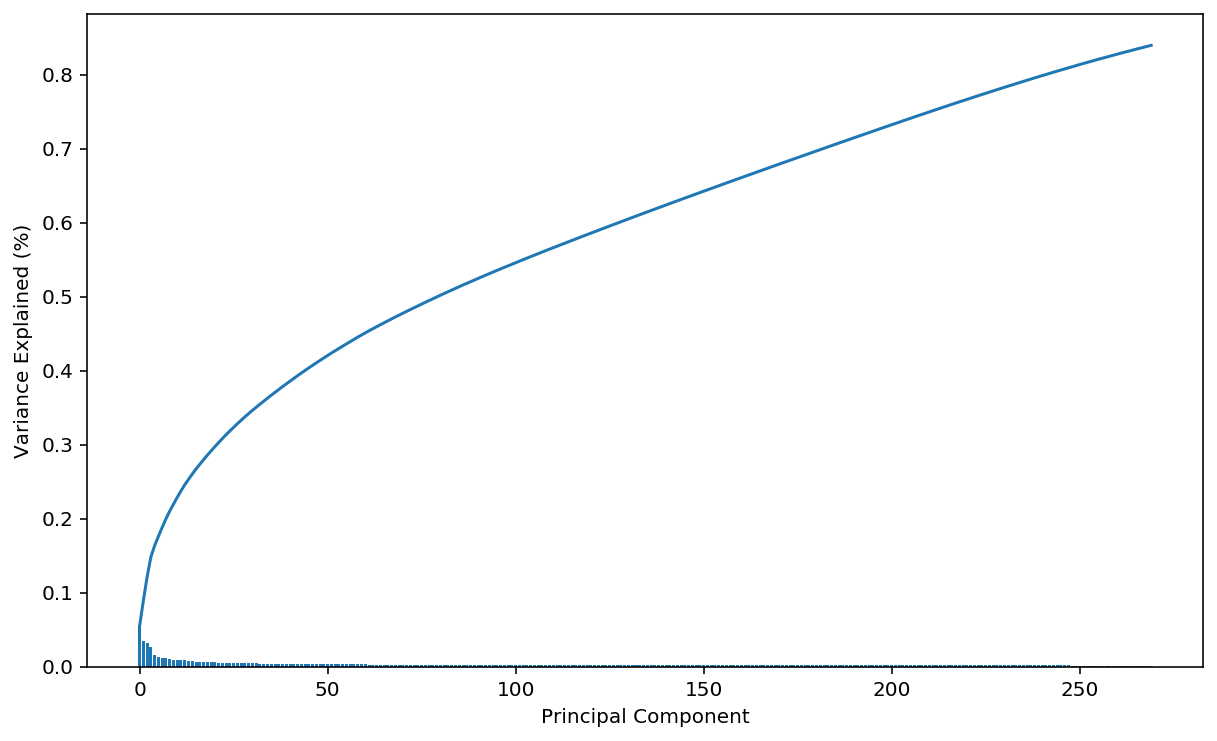

In [47]:
# Analyze the variance accounted for by each principal component.

ind = np.arange(n_components)
vals = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))

ax = plt.subplot()
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)

for i in range(n_components):
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    
plt.savefig('pca.png', dpi=500, bbox_inches='tight', pad_inches=0)

In [48]:
pca.components_.shape

(270, 562)

In [49]:
# Re-apply PCA to the data while selecting for number of components to retain.
sum(pca.explained_variance_ratio_)

0.8396026061441857

### Clustering (Kmeans)

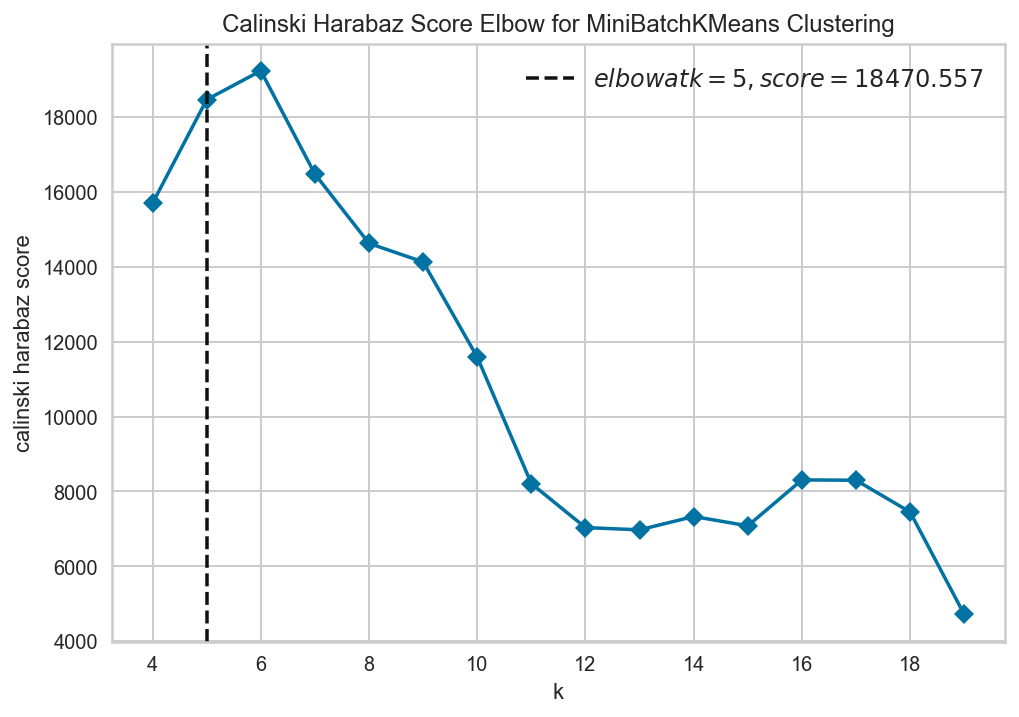

In [50]:
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = MiniBatchKMeans()
visualizer = KElbowVisualizer(
    model, k=(4,20), metric='calinski_harabasz', timings=False
)

visualizer.fit(azdias_pca)        # Fit the data to the visualizer
visualizer.show(outpath="/Users/selmee/Desktop/kmeans_elbow.png")

In [51]:
optimal_k = 8
kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=15)
model = kmeans.fit(azdias_pca)

In [52]:
preds = model.predict(azdias_pca)

azdias_preds = pd.DataFrame(preds, columns=['General_Population'])

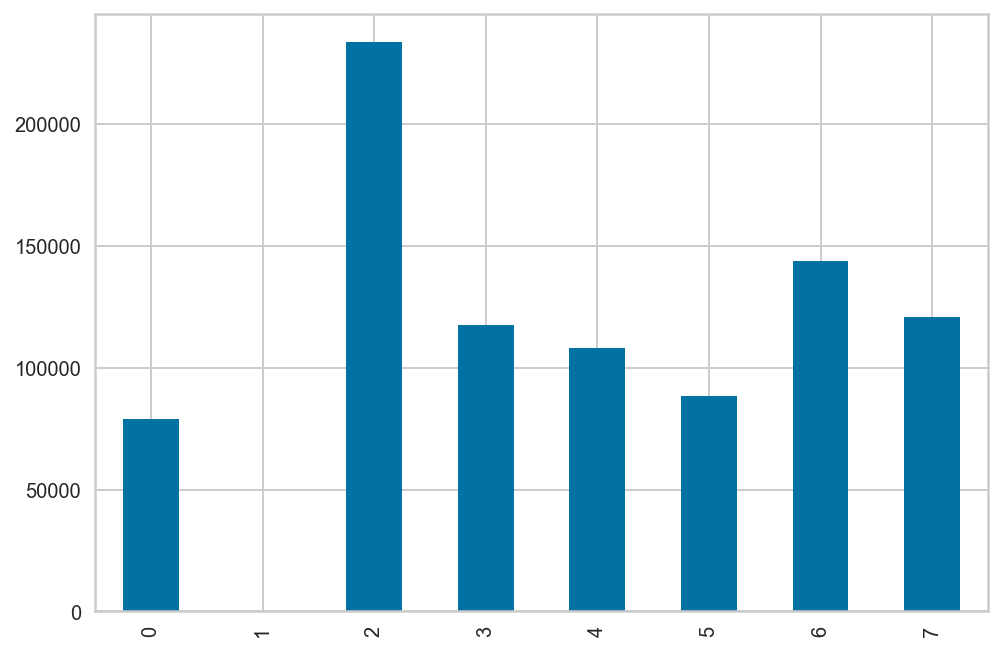

In [53]:
azdias_preds['General_Population'].value_counts().sort_index().plot(kind='bar')

### Customer data clustering

In [54]:
customers_impute = imputer.transform(customers)
customers_scaled = scaler.transform(customers_impute)
customers_pca = pca.transform(customers_scaled)
customers_preds = model.predict(customers_pca)

In [55]:
customers_preds = pd.DataFrame(customers_preds, columns=['Customers_Population'])

In [56]:
data_clusters = pd.concat([customers_preds['Customers_Population'].value_counts(), 
                           azdias_preds['General_Population'].value_counts()], axis=1)

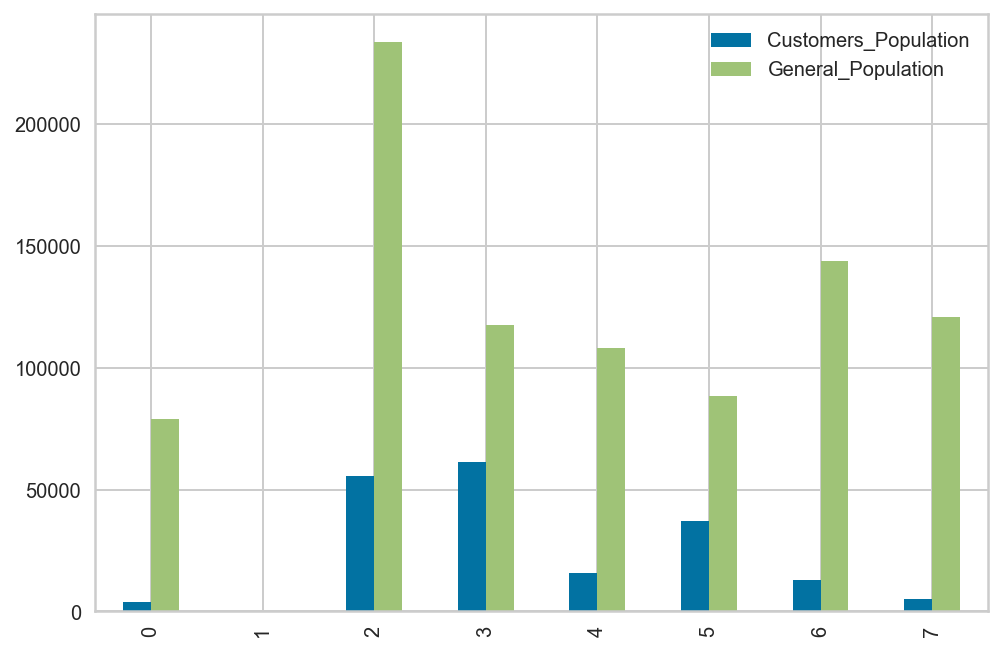

In [57]:
data_clusters.plot(kind='bar')
plt.savefig('clusters_comparison.png', dpi=500, bbox_inches='tight', pad_inches=0)

In [58]:
# What people are more likely to be customers?
target_list = azdias_preds[azdias_preds['General_Population'] == 3].index
df_target = azdias.iloc[target_list]
df_target.head(3)

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_INTL_2015,...,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,WOHNLAGE_0.0,WOHNLAGE_1.0,WOHNLAGE_2.0,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0
12,5.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,2.0,43.0,...,0,0,0,0,0,1,0,0,0,0
39,1.0,1.0,0.0,2.0,3.0,1.0,0.0,3.0,6.0,NaN,...,0,0,0,0,1,0,0,0,0,0
45,1.0,1.0,0.0,1.0,5.0,1.0,0.0,3.0,7.0,41.0,...,0,0,0,0,0,0,0,0,1,0


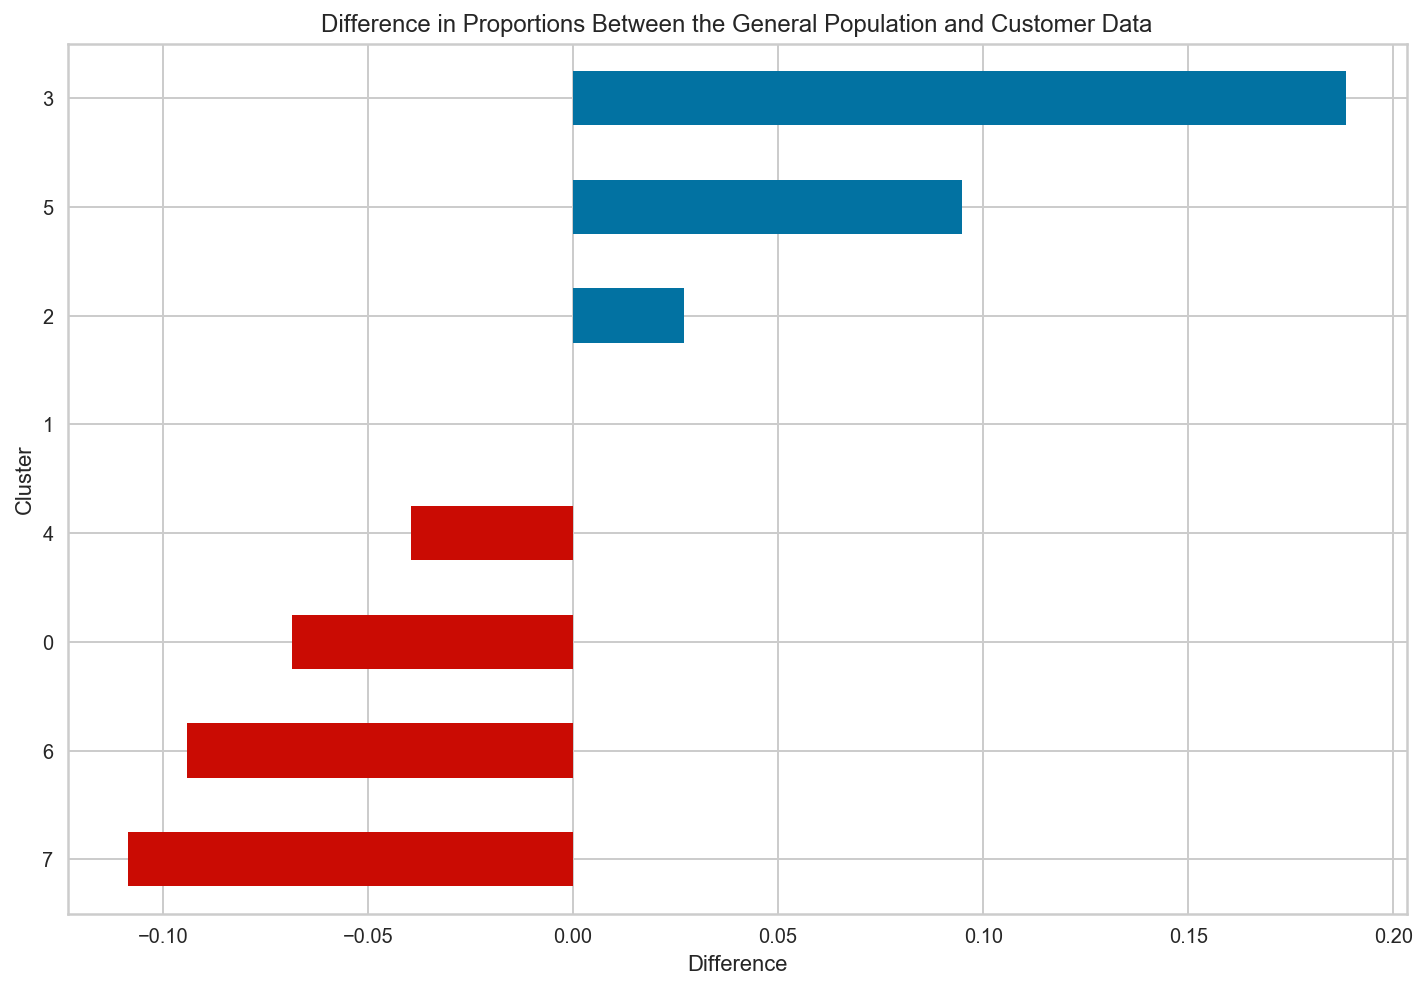

In [59]:
# Check for overrepresentation and underrepresentation of clusters between the two datasets
azdias_prop = azdias_preds['General_Population'].value_counts() / azdias.shape[0]
customers_prop = customers_preds['Customers_Population'].value_counts() / customers.shape[0]
diff_prop = customers_prop - azdias_prop

max_index = diff_prop.sort_values(ascending=False).index[0]
max_diff = diff_prop.sort_values(ascending=False).iloc[0]
min_index = diff_prop.sort_values(ascending=False).index[-6]
min_diff = diff_prop.sort_values(ascending=False).iloc[-6]

fig, ax = plt.subplots(figsize=(12,8))

diff_vals = diff_prop.sort_values()
diff_vals.plot(kind='barh', color=(diff_vals > 0).map({True: 'b', False: 'r'}))
plt.title("Difference in Proportions Between the General Population and Customer Data")
plt.xlabel("Difference")
plt.ylabel("Cluster");

In [60]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
print('The cluster which is the most overrepresented is cluster {} with a difference of {}.'
         .format(max_index, np.round(max_diff, 4)))

The cluster which is the most overrepresented is cluster 3 with a difference of 0.1884.


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [61]:
mailout_train = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype={18:'str',19:'str'})

In [62]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [63]:
# Prepare the data using the function created earlier
mailout_train_clean = clean_data(mailout_train)

passing RESPONSE


In [64]:
y = mailout_train_clean['RESPONSE']

In [65]:
# Check for missing column in `clean_mailout_train`
missing = list(np.setdiff1d(mailout_train_clean.columns, azdias.columns))

for col in missing:
    try:
        mailout_train_clean.drop(col, axis=1, inplace=True)
    except:
        print('warning:', col)    

In [66]:
X = mailout_train_clean
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [76]:
def build_model():

    """Build model.
    Returns: 
        pipline: sklearn.model_selection.GridSearchCV. Random Forest Classifier.
    """

    # Set machine learning pipeline
    
    pipeline = Pipeline([
            ('imp', Imputer(missing_values='NaN', axis=0)),
            ('scale', scaler),
            ('clf', RandomForestClassifier(n_estimators=10, n_jobs=2))
    ])
        
    parameters = {}
    parameters['imp__strategy'] = ['mean', 'median', 'most_frequent']
    parameters['clf__n_estimators'] = [5, 10]

    # Set parameters for gird search
    cv = GridSearchCV(pipeline, parameters, scoring='roc_auc', n_jobs= 1)

    return cv


print('Building model...')
model = build_model()
        
print('Training model...')
model.fit(X_train, y_train)

Building model...
Training model...


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is 

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_...n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'imp__strategy': ['mean', 'median', 'most_frequent'], 'clf__n_estimators': [5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [79]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_val)

accuracy_score(y_val, y_pred)

0.9873152566042127

In [120]:
(y_train == 0).sum()

33946

In [119]:
(y_train == 1).sum()

423

In [121]:
y_pred = model.predict(X_train)

accuracy_score(y_train, y_pred)

0.9956937938258315

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [94]:
mailout_test = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype={18:'str',19:'str'})

In [96]:
index_LNX = mailout_test['LNR']

In [105]:
# Prepare the data using the function created earlier
mailout_test_clean = clean_data(mailout_test)

In [108]:
# Check for missing column in `clean_mailout_train`
missing = list(np.setdiff1d(mailout_test_clean.columns, azdias.columns))

for col in missing:
    try:
        mailout_test_clean.drop(col, axis=1, inplace=True)
    except:
        print('warning:', col)    

In [109]:
y_pred = model.predict(mailout_test_clean)

In [110]:
submission = pd.DataFrame(index=index_LNX.astype('int32'), data=y_pred)

In [111]:
submission.rename(columns={0: "RESPONSE"}, inplace=True)
submission.head()

,RESPONSE
LNR,
1754,0
1770,0
1465,0
1470,0
1478,0


In [112]:
submission.to_csv('submission.csv')